<a href="https://colab.research.google.com/github/MiguelUrenaPliego/labTopoSAM/blob/main/SAM_segmentar_con_texto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generador segmentar a partir de texto

Si se ejecuta desde colab:

Ir a enotrno de ejecución -> Cambiar tipo de entorno de ejecución: en Acelerador por hadware y seleccionar GPU tipo de GPU T4

Si se ejecuta en local:

Comprobar que se tiene una GPU Nvidia con sus drivers y cuda toolkit instalado
drivers https://www.nvidia.es/Download/index.aspx?lang=es
cuda toolkit https://developer.nvidia.com/cuda-downloads

Fuente:  segment-anything/notebooks/automatic_mask_generator_example.ipynb

In [1]:
%pip install segment-geospatial groundingdino-py leafmap localtileserver #para instalar algunas librerías

In [2]:
import leafmap #leafmap sirve para descargar imágenes de google earth engine https://leafmap.org/#introduction
from samgeo import tms_to_geotiff
from samgeo.text_sam import LangSAM

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

## Cargar imágenes

Hay dos opciones

### Opción 1: Descarga de imágenes desde google earth

Generamos un mapa interactivo
Veremos una ventana con la imagen de google earth.
La llevamos a la zona que queremos estudiar y con las herramientas de la izquiera hacemos un polígono. Es recomendable estudiar una zona pequeña para que no tarde mucho el procesado.

In [3]:
m = leafmap.Map(center=[43.2294769, -7.5824514], zoom=17, height="800px") # center=[lat, lon]
m.add_basemap("SATELLITE")
m.add_basemap("HYBRID")
m

Map(center=[43.2294769, -7.5824514], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title…

In [35]:
if m.user_roi_bounds() is not None:
    bbox = m.user_roi_bounds()
else:
    bbox = "No has seleccionado nada"
    print("No has seleccionado nada")
    #bbox = [-122.2659, 37.8682, -122.2521, 37.8741]
bbox

[-7.5623, 43.2343, -7.5536, 43.2378]

bbox es una variable con las coordenadas del polígono que has seleccionado

### Descarga de las imágenes dentro del polígono seleccionado

In [36]:
image = "satellite.tif"
tms_to_geotiff(output=image, bbox=bbox, zoom=17, source="Satellite", overwrite=True)

Downloaded image 01/12
Downloaded image 02/12
Downloaded image 03/12
Downloaded image 04/12
Downloaded image 05/12
Downloaded image 06/12
Downloaded image 07/12
Downloaded image 08/12
Downloaded image 09/12
Downloaded image 10/12
Downloaded image 11/12
Downloaded image 12/12
Saving GeoTIFF. Please wait...
Image saved to satellite.tif


### Opción 2: Cargar imágenes desde archivo local
Puedes cargar tu propia imagen escribiendo la ruta. Debe ser un formato .tif con 3 canales R (rojo) G (verde) B (azul)

In [ ]:
# image = '/path/to/your/own/image.tif'

Vemos las imágenes descargadas sobre el mapa

In [37]:
m.layers[-1].visible = False #Si da error vuelve a ejecutar la celda de nuevo
m.add_raster(image, layer_name="Image")
m

Map(bottom=12299912.0, center=[43.23526099153074, -7.556176052622682], controls=(ZoomControl(options=['positio…

## Inicialización de SAM
SAM segment anything es un modelo de segmentación de imágenes desarrollado por meta https://github.com/facebookresearch/segment-anything . Tiene una versión especial para imágenes satélite https://samgeo.gishub.org/ .

Para que el procesamiento sea rápido requiere una GPU. En google collab lo hemos configurado ya en el primer paso.

Descargamos SamGeo (Puede tardar unos minutos dependiendo de tu internet)

Inicialización del modelo

In [7]:
sam = LangSAM()

final text_encoder_type: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading: "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth" to /root/.cache/torch/hub/checkpoints/sam_vit_h_4b8939.pth
100%|██████████| 2.39G/2.39G [00:15<00:00, 165MB/s]


Especifica la clase que quieres segmentar

In [56]:
text_prompt = "house"

## Segmentación de la imagen

El resultado se guarda en el formato GEOtiff

box_threshold [0,1] tolerancia de deteccion. Valores altos dan lugar a detecciones muy seguras pero probablemente se pasen por alto bastantes elementos. valores bajos dan lugar a detecciones menos seguras con riesgo de detectar mal algunos elementos.

text_threshold [0,1] El modelo interpreta el texto que le damos para buscar la clase necesaria. Se puede escribir en text_promt cualquier cosa. Valores altos de text_threshold dan lugar a mayor exigencia del modelo para encontrar clases parecidas al texto dado. Valores bajos daran lugar a coincidencias más generales.

In [57]:
sam.predict(image, text_prompt, box_threshold=0.2, text_threshold=0.2)

## Visualización de resultados

Valores para cmap 'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
                      'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
                      'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn' y los que acepta matplotlib

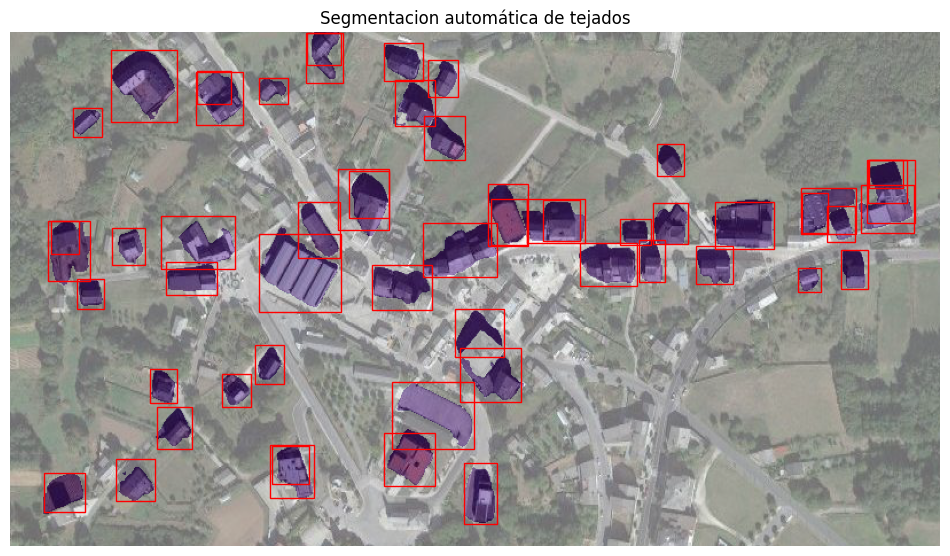

In [58]:
sam.show_anns(
    cmap='Purples',
    box_color='red',
    title='Segmentacion automática de tejados',
    blend=True,
)

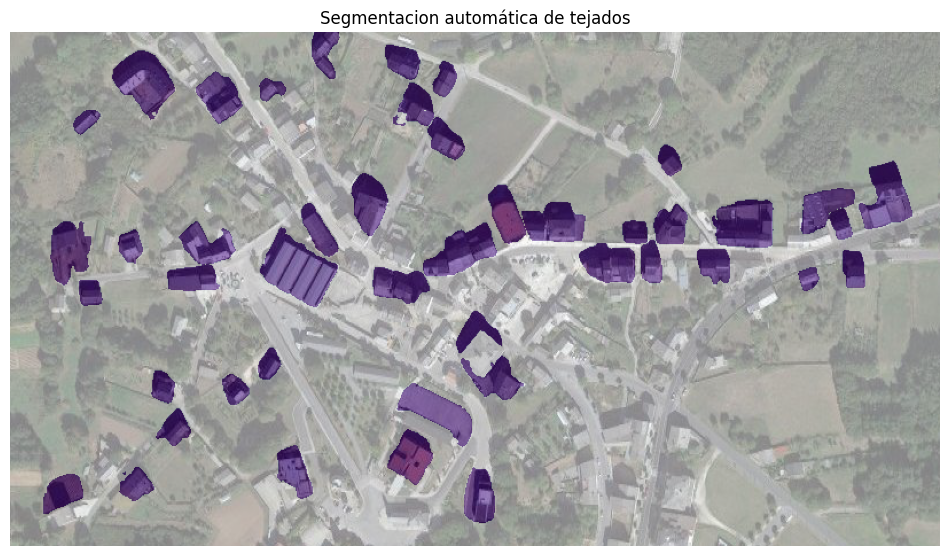

In [59]:
sam.show_anns(
    cmap='Purples',
    add_boxes=False, # Sin cajas en las detecciones
    alpha=0.5,
    title='Segmentacion automática de tejados',
)

##Guardar resultados

Gardarmos los resultados creando una máscara en formato .tiff

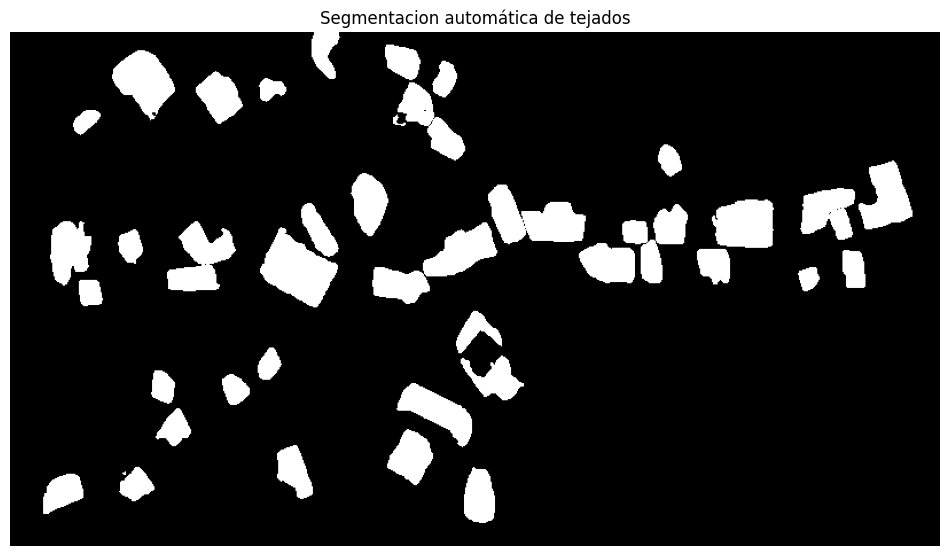

In [62]:
sam.show_anns(
    cmap='Greys_r',
    add_boxes=False,
    alpha=1,
    title='Segmentacion automática de tejados',
    blend=False,
    output='buildings.tif',
)

Guardar resultados en formato vectorial .shp

In [63]:
sam.raster_to_vector("buildings.tif", "buildings.shp")

## Imagen interactiva

In [67]:
m.add_raster("buildings.tif", layer_name="Trees", palette="Greens", opacity=0.5, nodata=0)
style = {
    "color": "#3388ff",
    "weight": 2,
    "fillColor": "#7c4185",
    "fillOpacity": 0.5,
}
m.add_vector("buildings.shp", layer_name="Vector", style=style)
m

Map(bottom=12299811.0, center=[43.23604999999998, -7.55795], controls=(ZoomControl(options=['position', 'zoom_…

## Hacer segmentación con un mapa interactivo

In [ ]:
sam.show_map()

Map(bottom=61589228.0, center=[14.644067470180794, -90.51144226921912], controls=(ZoomControl(options=['positi…

Comparación de imagen y máscara con slider

In [ ]:
overlay_images(image, "annotations.tif", backend="TkAgg") # No funciona en google Colab

The TkAgg backend is not supported in Google Colab. The overlay_images function will not work on Colab.


Para guardar máscara en formato vectorial


In [ ]:
sam.tiff_to_vector("masks.tif", "masks.gpkg")